# Writing your own trajectory analysis

We create our own analysis methods for calculating the radius of gyration of a selection of atoms.

This can be done three ways, from least to most flexible:

 1. [Running the analysis directly from a function](#Creating-an-analysis-from-a-function)
 
 2. [Turning a function into a class](#Transforming-a-function-into-a-class)
 
 3. [Writing your own class](#Creating-your-own-class)

The building blocks and methods shown here are only suitable for analyses that involve iterating over the trajectory once.

If you implement your own analysis method, please consider [contributing it to the MDAnalysis codebase!](https://www.mdanalysis.org/UserGuide/contributing.html)

**Last executed:** Feb 07, 2020 with MDAnalysis 0.20.2-dev0

**Last updated:** February 2020

**Minimum version of MDAnalysis:** 0.19.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests


In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Radius of gyration

Let's start off by defining a standalone analysis function.

The radius of gyration of a structure measures how compact it is. In [GROMACS](http://manual.gromacs.org/documentation/2019-rc1/reference-manual/analysis/radius-of-gyration.html), it is calculated as follows: 

$$ R_g = \sqrt{\frac{\sum_i m_i \mathbf{r}_i^2}{\sum_i m_i}}$$

where $m_i$ is the mass of atom $i$ and $\mathbf{r}_i$ is the position of atom $i$, relative to the center-of-mass of the selection.

The radius of gyration around each axis can also be determined separately. For example, the radius of gyration around the x-axis:

$$ R_{i, x} = \sqrt{\frac{\sum_i m_i [r_{i, y}^2 + r_{i, z}^2]}{\sum_i m_i}}$$

Below, we define a function that takes an AtomGroup and calculates the radii of gyration. We could write this function to only need the AtomGroup. However, we also add in a `masses` argument and a `total_mass` keyword to avoid recomputing the mass and total mass for each frame.

In [2]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)

In [3]:
u = mda.Universe(PSF, DCD)
protein = u.select_atoms('protein')

u2 = mda.Universe(PSF, DCD2)

## Creating an analysis from a function

`MDAnalysis.analysis.base.AnalysisFromFunction` can create an analysis from a function that works on AtomGroups. It requires the function itself, the trajectory to operate on, and then the arguments / keyword arguments necessary for the function.

In [4]:
rog = AnalysisFromFunction(radgyr, u.trajectory, 
                           protein, protein.masses, 
                           total_mass=np.sum(protein.masses))
rog.run();

Running the analysis iterates over the trajectory. The output is saved in `rog.results`, which has the same number of rows, as frames in the trajectory.

In [5]:
rog.results.shape

(98, 4)

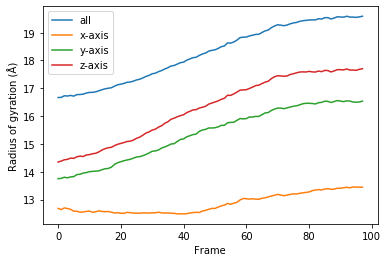

In [6]:
labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(rog.results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

You can also re-run the analysis with different frame selections. 

Below, we start from the 10th frame and take every 8th frame until the 80th. Note that the slice includes the `start` frame, but does not include the `stop` frame index (much like the actual `range()` function).

In [7]:
rog_10 = AnalysisFromFunction(radgyr, u.trajectory, 
                              protein, protein.masses, 
                              total_mass=np.sum(protein.masses))

rog_10.run(start=10, stop=80, step=7)
rog_10.results.shape

(10, 4)

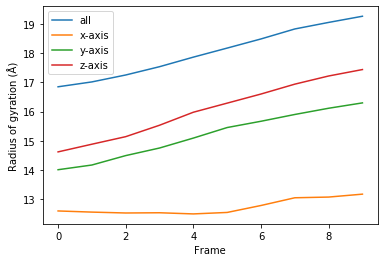

In [8]:
for col, label in zip(rog_10.results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

## Transforming a function into a class

While the `AnalysisFromFunction` is convenient for quick analyses, you may want to turn your function into a class that can be applied to many different trajectories, much like other MDAnalysis analyses.

You can apply `analysis_class` to any function that you can run with `AnalysisFromFunction` to get a class.

In [9]:
RadiusOfGyration = analysis_class(radgyr)

To run the analysis, pass exactly the same arguments as you would for `AnalysisFromFunction`.

In [10]:
rog_u1 = RadiusOfGyration(u.trajectory, protein, 
                          protein.masses,
                          total_mass=np.sum(protein.masses))
rog_u1.run();

As with `AnalysisFromFunction`, the results are in `results`.

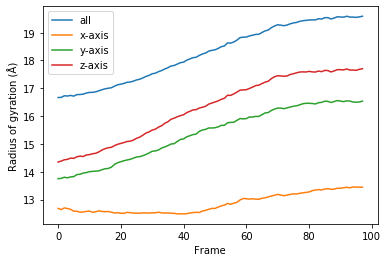

In [11]:
for col, label in zip(rog_u1.results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

You can reuse the class for other trajectories and selections.

In [12]:
ca = u2.select_atoms('name CA')

rog_u2 = RadiusOfGyration(u2.trajectory, ca, 
                          ca.masses,
                          total_mass=np.sum(ca.masses))
rog_u2.run();

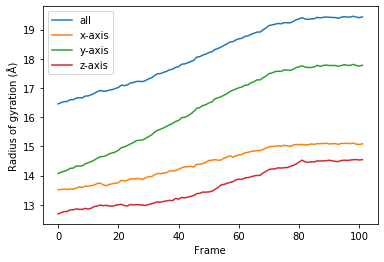

In [13]:
for col, label in zip(rog_u2.results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

## Creating your own class

Although `AnalysisFromFunction` and `analysis_class` are convenient, they can be too limited for complex algorithms. You may need to write your own class.

MDAnalysis provides the `MDAnalysis.analysis.base.AnalysisBase` class as a template for creating multiframe analyses. This class automatically sets up your trajectory reader for iterating, and includes an optional progress meter. 

The analysis is always run by calling `run()`. `AnalysisFromFunction` actually subclasses `AnalysisBase`, and `analysis_class` returns a subclass of `AnalysisFromFunction`, so the behaviour of `run()` remains identical.

### 1. Define `__init__`
You can define a new analysis by subclassing AnalysisBase. Initialise the analysis with the `__init__` method, where you *must* pass the trajectory that you are working with to `AnalysisBase.__init__()`. You can also pass in the `verbose` keyword. If `verbose=True`, the class will set up a progress meter for you.

### 2. Define your analysis in `_single_frame()` and other methods
Implement your functionality as a function over each frame of the trajectory by defining `_single_frame()`. This function gets called for each frame of your trajectory. 

You can also define `_prepare()` and `_conclude()` to set your analysis up before looping over the trajectory, and to finalise the results that you have prepared. In order, `run()` calls:

 - `_prepare()`
 - `_single_frame()` (for each frame of the trajectory that you are iterating over)
 - `_conclude()`

Class subclassed from AnalysisBase can make use of several properties when defining the methods above:

 - `self.start`: frame index to start analysing from. Defined in `run()`
 - `self.stop`: frame index to stop analysis. Defined in `run()`
 - `self.step`: number of frames to skip in between. Defined in `run()`
 - `self.n_frames`: number of frames to analyse over. This can be helpful in initialising result arrays.
 - `self._verbose`: whether to be verbose.
 - `self._trajectory`: the actual trajectory
 - `self._ts`: the current timestep object
 - `self._frame_index`: the index of the currently analysed frame. This is *not* the absolute index of the frame in the trajectory overall, but rather the relative index of the frame within the list of frames to be analysed. You can think of it as the number of times that `self._single_frame()` has already been called.
 
Below, we create the class `RadiusOfGyration2` to run the analysis function that we have defined above, and add extra information such as the time of the corresponding frame.

In [14]:
class RadiusOfGyration2(AnalysisBase):  # subclass AnalysisBase
    
    def __init__(self, atomgroup, verbose=True):
        """
        Set up the initial analysis parameters.
        """
        # must first run AnalysisBase.__init__ and pass the trajectory
        trajectory = atomgroup.universe.trajectory
        super(RadiusOfGyration2, self).__init__(trajectory,
                                               verbose=verbose)
        # set atomgroup as a property for access in other methods
        self.atomgroup = atomgroup
        # we can calculate masses now because they do not depend
        # on the trajectory frame.
        self.masses = self.atomgroup.masses
        self.total_mass = np.sum(self.masses)
    
    def _prepare(self):
        """
        Create array of zeroes as a placeholder for results.
        This is run before we begin looping over the trajectory.
        """
        # This must go here, instead of __init__, because
        # it depends on the number of frames specified in run().
        self.results = np.zeros((self.n_frames, 6))
        # We put in 6 columns: 1 for the frame index, 
        # 1 for the time, 4 for the radii of gyration
        
    def _single_frame(self):
        """
        This function is called for every frame that we choose
        in run().
        """
        # call our earlier function
        rogs = radgyr(self.atomgroup, self.masses,
                      total_mass=self.total_mass)
        # save it into self.results
        self.results[self._frame_index, 2:] = rogs
        # the current timestep of the trajectory is self._ts
        self.results[self._frame_index, 0] = self._ts.frame
        # the actual trajectory is at self._trajectory
        self.results[self._frame_index, 1] = self._trajectory.time
        
    def _conclude(self):
        """
        Finish up by calculating an average and transforming our
        results into a DataFrame.
        """
        # by now self.result is fully populated
        self.average = np.mean(self.results[:, 2:], axis=0)
        columns = ['Frame', 'Time (ps)', 'Radius of Gyration',
                   'Radius of Gyration (x-axis)',
                   'Radius of Gyration (y-axis)',
                   'Radius of Gyration (z-axis)',]
        self.df = pd.DataFrame(self.results, columns=columns)

Because `RadiusOfGyration2` calculates the masses of the selected AtomGroup itself, we do not need to pass it in ourselves.

In [15]:
rog_base = RadiusOfGyration2(protein, verbose=True).run()

Step    98/98 [100.0%]


As calculated in `_conclude()`, the average radii of gyrations are at `rog.average`.

In [16]:
rog_base.average

array([18.26549552, 12.85342131, 15.37359575, 16.29185734])

The results are available at `rog.results` as an array or `rog.df` as a DataFrame.

In [17]:
rog_base.df

,Frame,Time (ps),Radius of Gyration,Radius of Gyration (x-axis),Radius of Gyration (y-axis),Radius of Gyration (z-axis)
0,0.0,1.000000,16.669018,12.679625,13.749343,14.349043
1,1.0,2.000000,16.673217,12.640025,13.760545,14.382960
2,2.0,3.000000,16.731454,12.696454,13.801342,14.429350
3,3.0,4.000000,16.722283,12.677194,13.780732,14.444711
4,4.0,5.000000,16.743961,12.646981,13.814553,14.489046
...,...,...,...,...,...,...
93,93.0,93.999992,19.562034,13.421683,16.539112,17.653968
94,94.0,94.999992,19.560575,13.451335,16.508649,17.656678
95,95.0,95.999992,19.550571,13.445914,16.500640,17.646130
96,96.0,96.999991,19.568381,13.443243,16.507396,17.681294


Using this DataFrame we can easily plot our results.

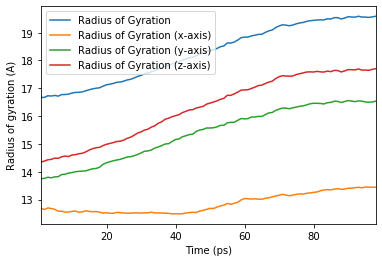

In [18]:
ax = rog_base.df.plot(x='Time (ps)', y=rog_base.df.columns[2:])
ax.set_ylabel('Radius of gyration (A)');

We can also run the analysis over a subset of frames, the same as the output from `AnalysisFromFunction` and `analysis_class`.

In [19]:
rog_base_10 = RadiusOfGyration2(protein, verbose=True)
rog_base_10.run(start=10, stop=80, step=7);

Step    10/10 [100.0%]


In [20]:
rog_base_10.results.shape

(10, 6)

In [21]:
rog_base_10.df

,Frame,Time (ps),Radius of Gyration,Radius of Gyration (x-axis),Radius of Gyration (y-axis),Radius of Gyration (z-axis)
0,10.0,10.999999,16.852127,12.584163,14.001589,14.614469
1,17.0,17.999998,17.019587,12.544784,14.163276,14.878262
2,24.0,24.999998,17.257429,12.514341,14.487021,15.137873
3,31.0,31.999997,17.542565,12.522147,14.747461,15.530339
4,38.0,38.999997,17.871241,12.482385,15.088865,15.977444
5,45.0,45.999996,18.182243,12.533023,15.451285,16.290153
6,52.0,52.999995,18.496493,12.771949,15.667003,16.603098
7,59.0,59.999995,18.839346,13.037335,15.900327,16.942533
8,66.0,66.999994,19.064333,13.061491,16.114195,17.222884
9,73.0,73.999993,19.276639,13.161863,16.298539,17.444213


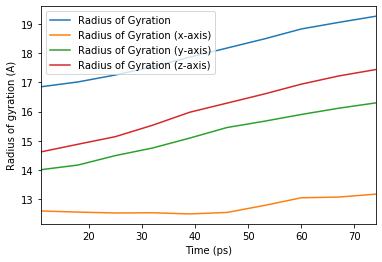

In [22]:
ax_10 = rog_base_10.df.plot(x='Time (ps)', 
                            y=rog_base_10.df.columns[2:])
ax_10.set_ylabel('Radius of gyration (A)');

## Contributing to MDAnalysis

If you think that you will want to reuse your new analysis, or that others might find it helpful, please consider [contributing it to the MDAnalysis codebase.](https://www.mdanalysis.org/UserGuide/contributing.html) Making your code open-source can have many benefits; others may notice an unexpected bug or suggest ways to optimise your code. If you write your analysis for a specific publication, please let us know; we will ask those who use your code to cite your reference in published work.

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.